In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

In [2]:
original_dataframe = pd.read_csv("VIW_FNT.csv")
df = original_dataframe

In [3]:
print(df.head())

  WHOREGION FLUSEASON HEMISPHERE           ITZ COUNTRY_CODE  \
0       AFR        NH         NH   FLU_NRT_AFR          DZA   
1       WPR        YR         NH   FLU_SE_ASIA          KHM   
2       EUR        NH         NH  FLU_CNT_ASIA          UZB   
3       AMR        YR         NH   FLU_CNT_AMC          NIC   
4       AFR        YR         NH   FLU_WST_AFR          CIV   

  COUNTRY_AREA_TERRITORY ISO_WEEKSTARTDATE  ISO_YEAR  ISO_WEEK  \
0                Algeria          11/29/21      2021        48   
1               Cambodia           6/15/15      2015        25   
2             Uzbekistan           2/13/17      2017         7   
3              Nicaragua           8/17/15      2015        34   
4          Côte d'Ivoire          10/29/12      2012        44   

  MMWR_WEEKSTARTDATE  ...  PARAINFLUENZA  RHINO  RSV  OTHERRESPVIRUS  \
0           11/28/21  ...            NaN    NaN  NaN             0.0   
1            6/14/15  ...            NaN    NaN  NaN             NaN   
2       

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139510 entries, 0 to 139509
Data columns (total 49 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   WHOREGION                139510 non-null  object 
 1   FLUSEASON                139510 non-null  object 
 2   HEMISPHERE               139510 non-null  object 
 3   ITZ                      139510 non-null  object 
 4   COUNTRY_CODE             139510 non-null  object 
 5   COUNTRY_AREA_TERRITORY   139510 non-null  object 
 6   ISO_WEEKSTARTDATE        139510 non-null  object 
 7   ISO_YEAR                 139510 non-null  int64  
 8   ISO_WEEK                 139510 non-null  int64  
 9   MMWR_WEEKSTARTDATE       139510 non-null  object 
 10  MMWR_YEAR                139510 non-null  int64  
 11  MMWR_WEEK                139510 non-null  int64  
 12  ORIGIN_SOURCE            139510 non-null  object 
 13  SPEC_PROCESSED_NB        131975 non-null  float64
 14  SPEC

In [5]:
df = df.loc[df['ISO_YEAR'] >= 2010]
df = df.loc[df['ORIGIN_SOURCE'] == 'SENTINEL']
df = df[['WHOREGION', 'COUNTRY_CODE', 'ISO_YEAR', 'ISO_WEEKSTARTDATE', 'ORIGIN_SOURCE', 'ADENO', 'BOCA', 'HUMAN_CORONA', 'METAPNEUMO', 'PARAINFLUENZA', 'RHINO', 'RSV']]
df = df[~df.isnull().any(axis = 1)]
df['week'] =  pd.to_datetime(df['ISO_WEEKSTARTDATE'])

### DATA CLEANING AND EXPLORATION

In [6]:
print(df.isnull().sum())
print(len(df))
print(df.info())

WHOREGION            0
COUNTRY_CODE         0
ISO_YEAR             0
ISO_WEEKSTARTDATE    0
ORIGIN_SOURCE        0
ADENO                0
BOCA                 0
HUMAN_CORONA         0
METAPNEUMO           0
PARAINFLUENZA        0
RHINO                0
RSV                  0
week                 0
dtype: int64
2261
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2261 entries, 114 to 139318
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   WHOREGION          2261 non-null   object        
 1   COUNTRY_CODE       2261 non-null   object        
 2   ISO_YEAR           2261 non-null   int64         
 3   ISO_WEEKSTARTDATE  2261 non-null   object        
 4   ORIGIN_SOURCE      2261 non-null   object        
 5   ADENO              2261 non-null   float64       
 6   BOCA               2261 non-null   float64       
 7   HUMAN_CORONA       2261 non-null   float64       
 8   METAPNEUMO       

In [7]:
unique_country = set(df['COUNTRY_CODE'])
unique_region = set(df['WHOREGION'])
unique_columns = df.columns
unique_columns = unique_columns.drop(['WHOREGION', 'COUNTRY_CODE', 'ISO_YEAR', 'ISO_WEEKSTARTDATE', 'ORIGIN_SOURCE'])

In [8]:
# for country in unique_country:
#     for col in unique_columns:
#         sns.lineplot(data = df, x = 'ISO_WEEKSTARTDATE', y = col).set(xticklabels = [])
#         plt.title(country)
#         plt.show()

In [9]:
unique_year = set(df['ISO_YEAR'])
years = sorted(list(unique_year))

In [10]:
# for country in unique_country: 
#     for column in unique_columns:
#         sns.barplot(data = df, x = 'ISO_YEAR', y = column).set_xticklabels(labels = years, rotation = 90)
#         plt.title(country)
#         plt.show()

In [11]:
mex = df.loc[df['COUNTRY_CODE'] == 'MEX']

In [12]:
ts = mex.loc[:, ['week', 'RSV']]
ts = ts.sort_values(by = ['week'])
ts.index = ts.week
ts = ts.drop("week", axis = 1)

In [13]:
print(ts)

             RSV
week            
2019-12-30  12.0
2020-01-06  12.0
2020-01-13  14.0
2020-01-20   9.0
2020-01-27   9.0
...          ...
2023-01-16  39.0
2023-01-23  47.0
2023-01-30  36.0
2023-02-06  27.0
2023-02-13   5.0

[164 rows x 1 columns]


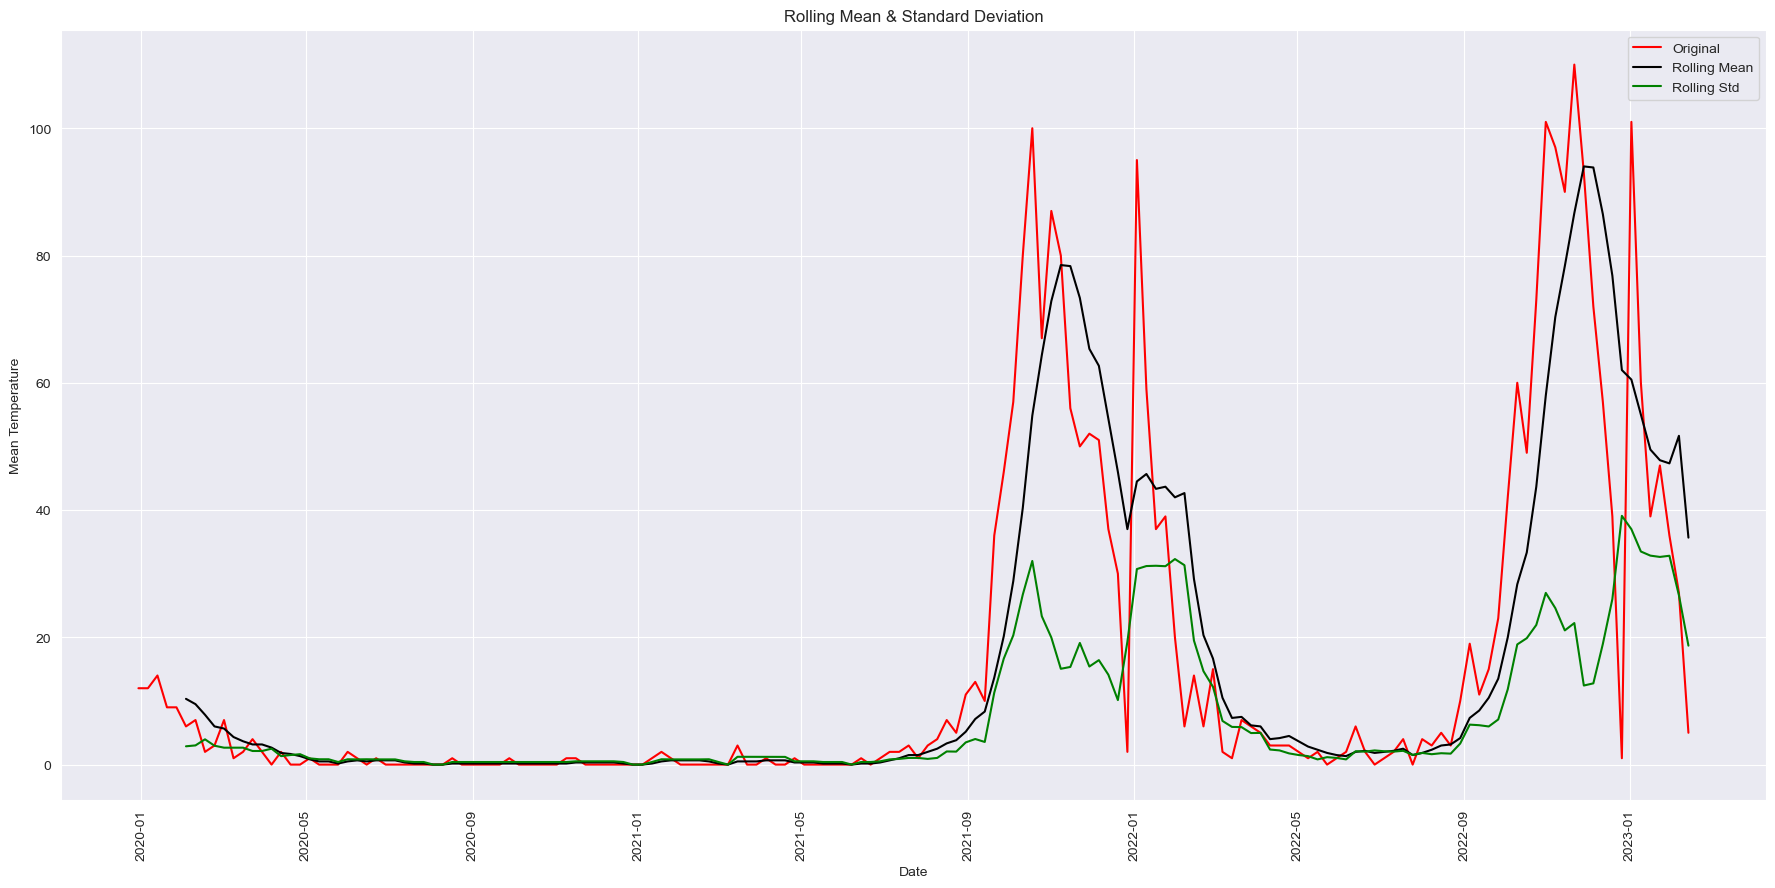

Test statistic:  -2.4778510673321366
p-value:  0.12095682221198406
Critical Values: {'1%': -3.4718957209472654, '5%': -2.8797795410156253, '10%': -2.5764947265625}


In [14]:
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xticks(rotation = 90)
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts)
check_adfuller(ts.RSV)

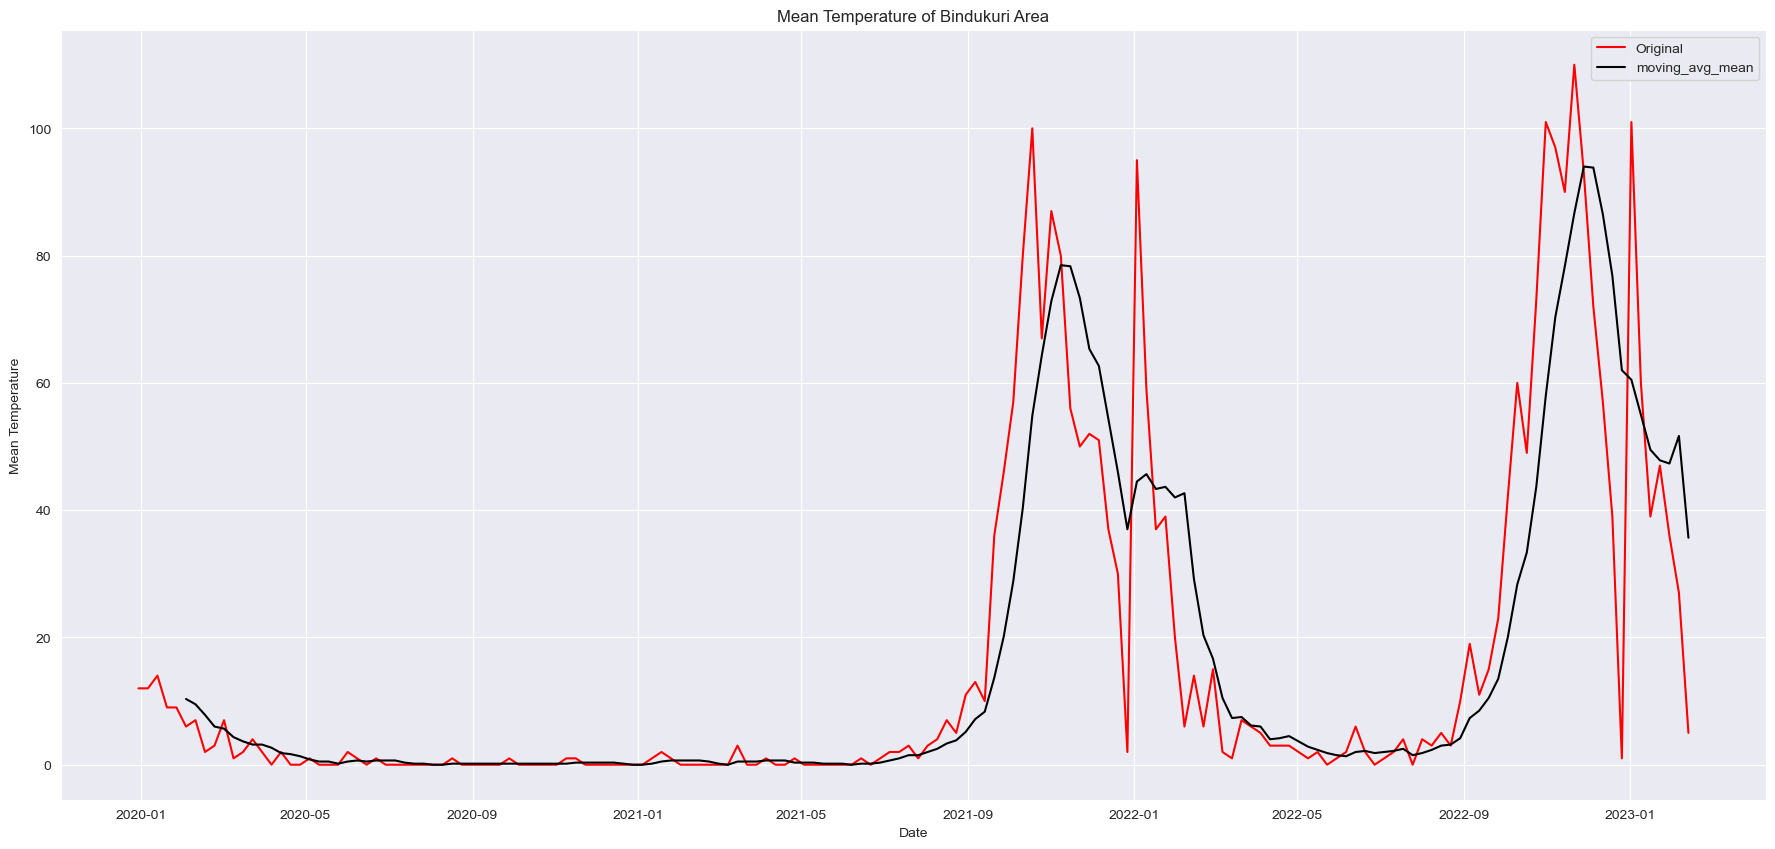

In [15]:
window_size = 6
moving_avg = ts.rolling(6).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

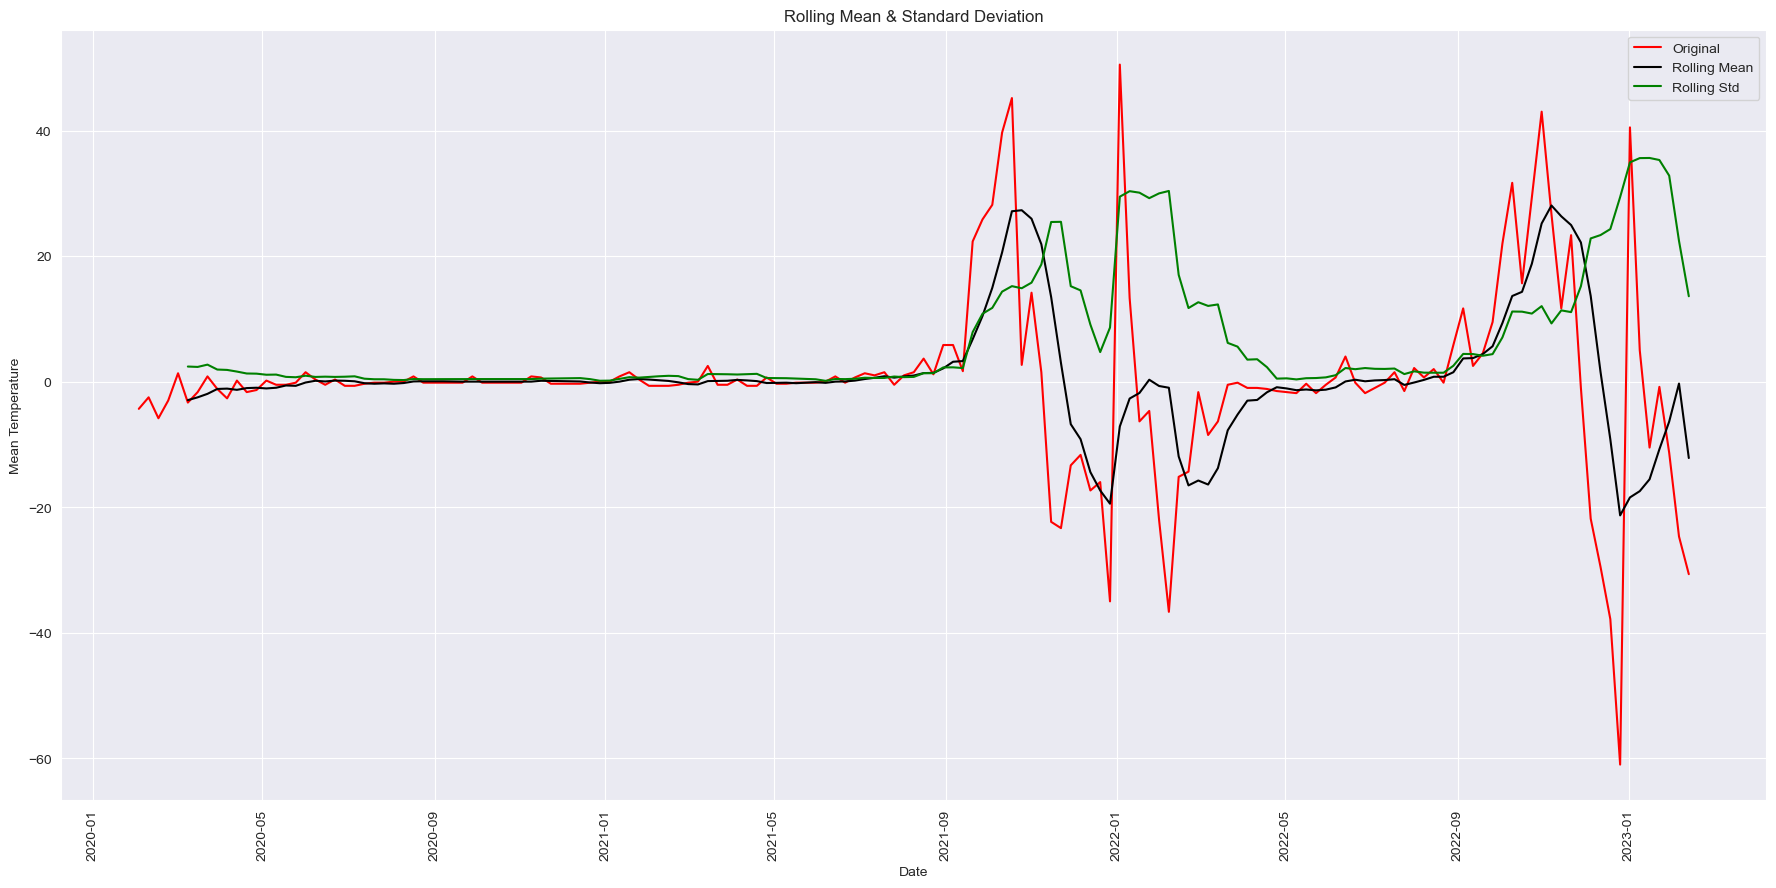

Test statistic:  -5.143381518120852
p-value:  1.1460225653426692e-05
Critical Values: {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}


In [16]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 6 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff.RSV)

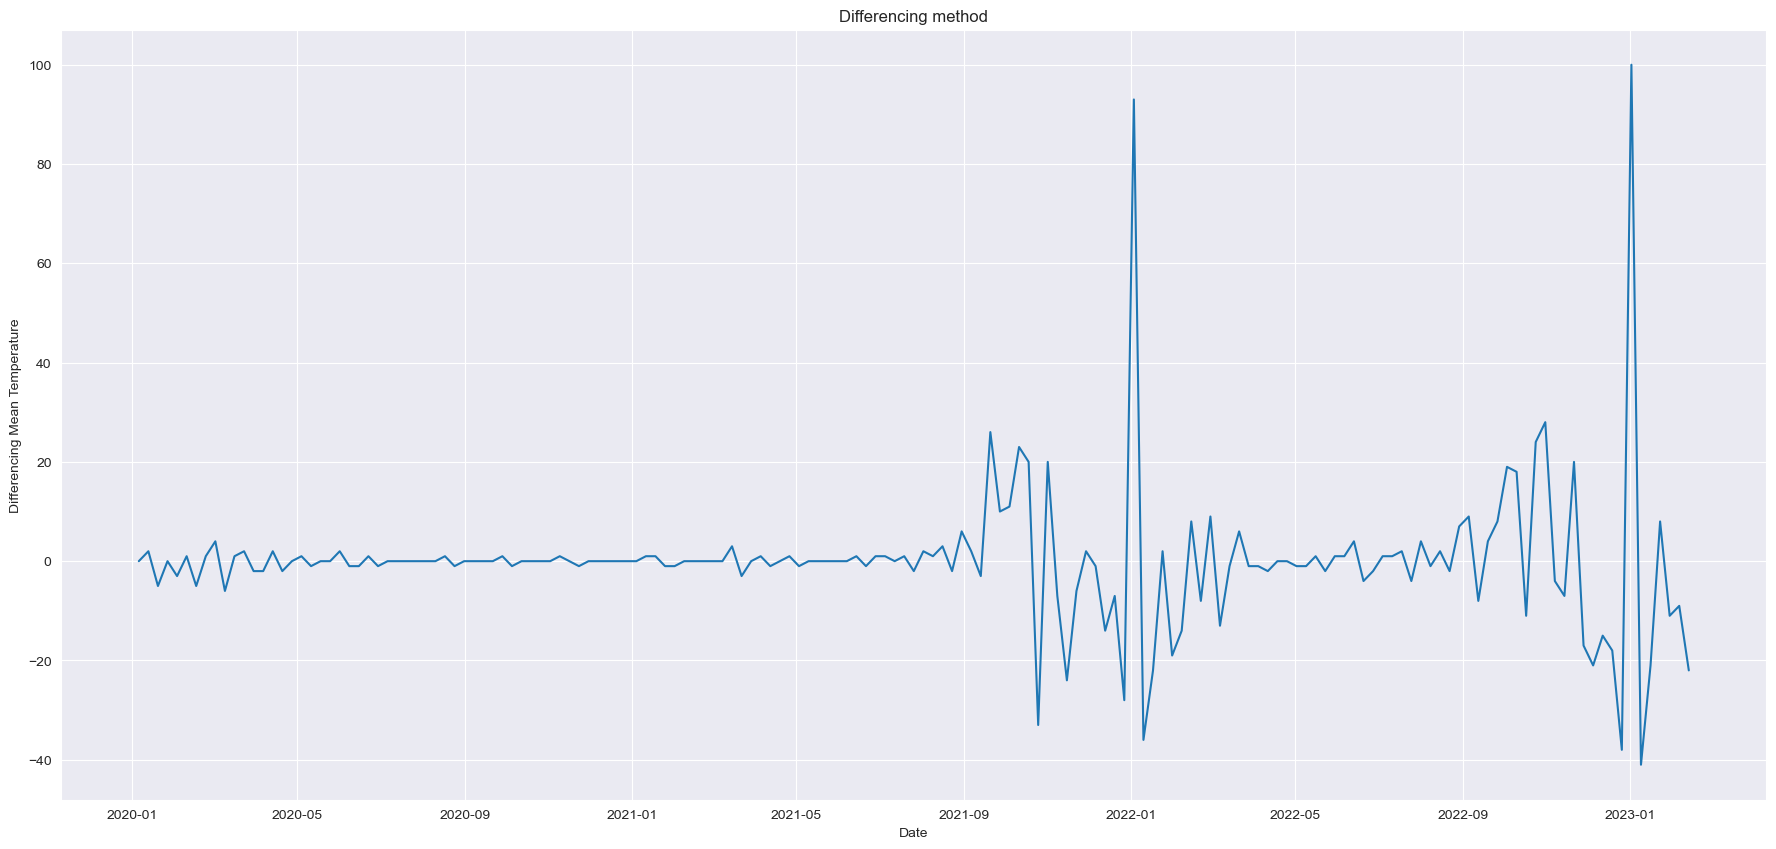

In [17]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

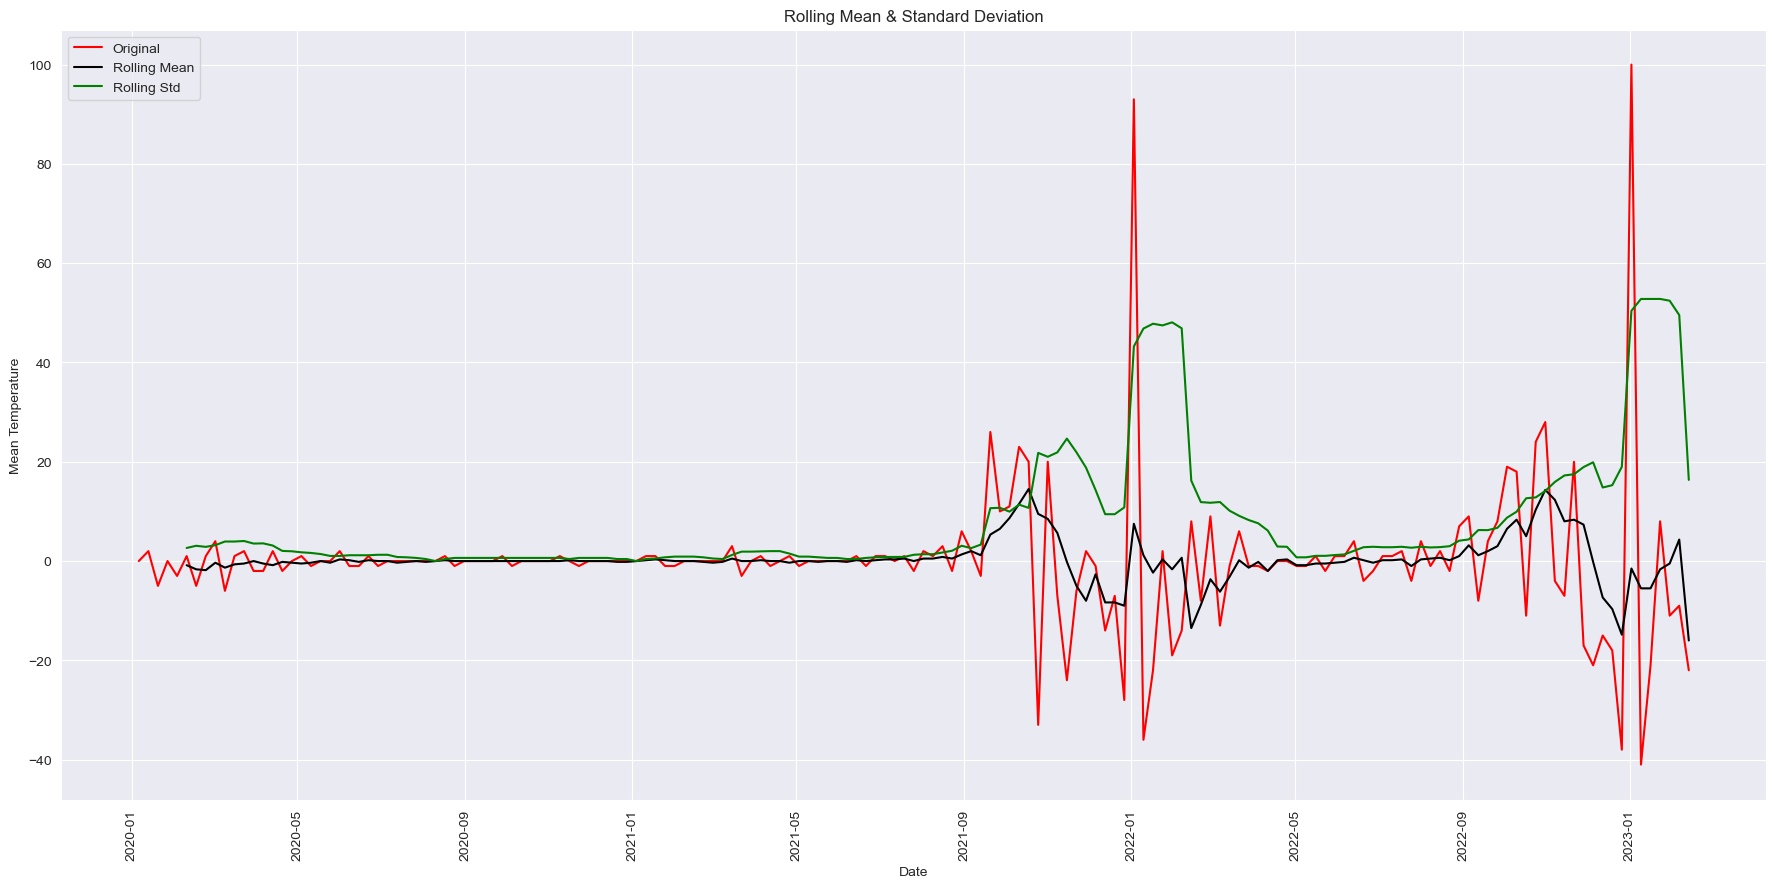

Test statistic:  -12.077951886393244
p-value:  2.2670544149136995e-22
Critical Values: {'1%': -3.471633386932248, '5%': -2.8796651107461972, '10%': -2.576433647235832}


In [18]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff.RSV)

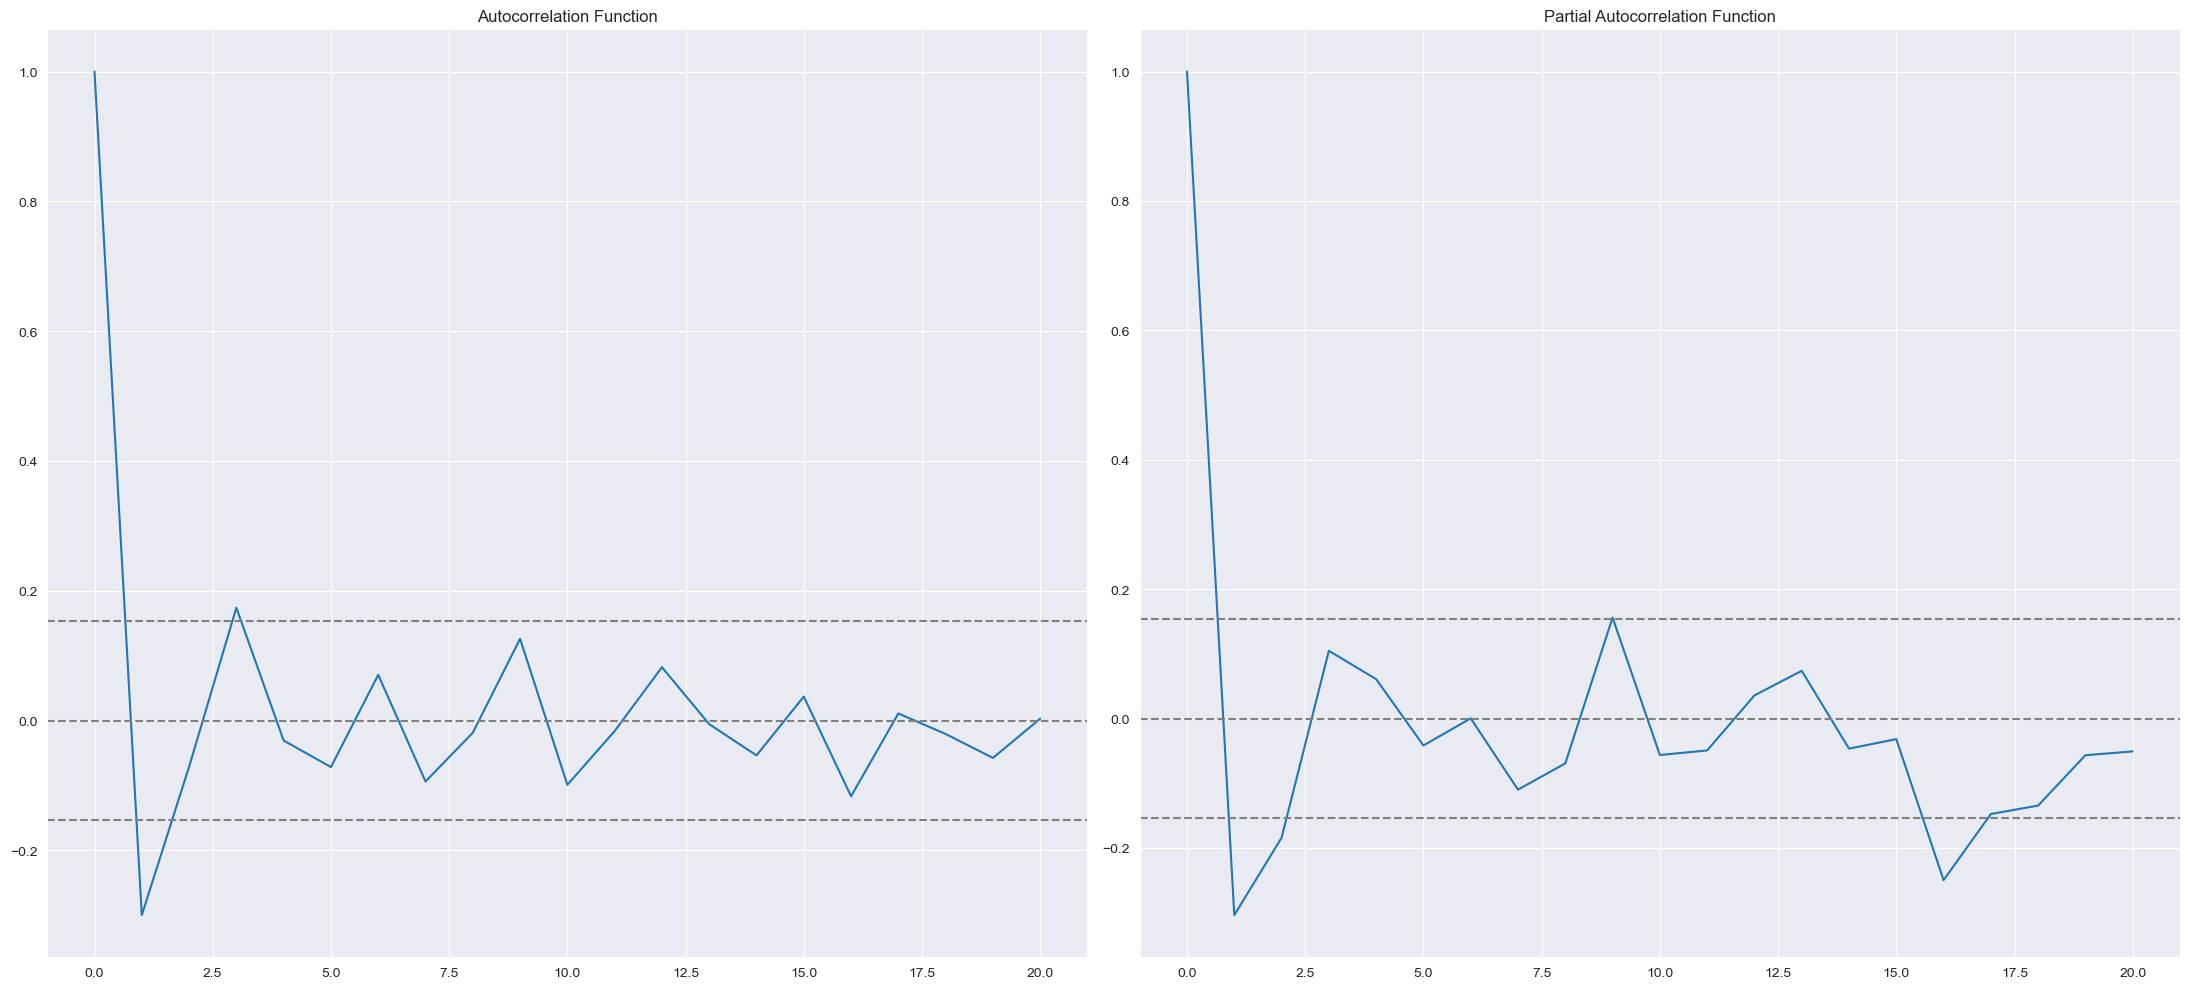

In [19]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [20]:
a = datetime(2022, 1, 1)


/Users/jonathanyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/jonathanyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/jonathanyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


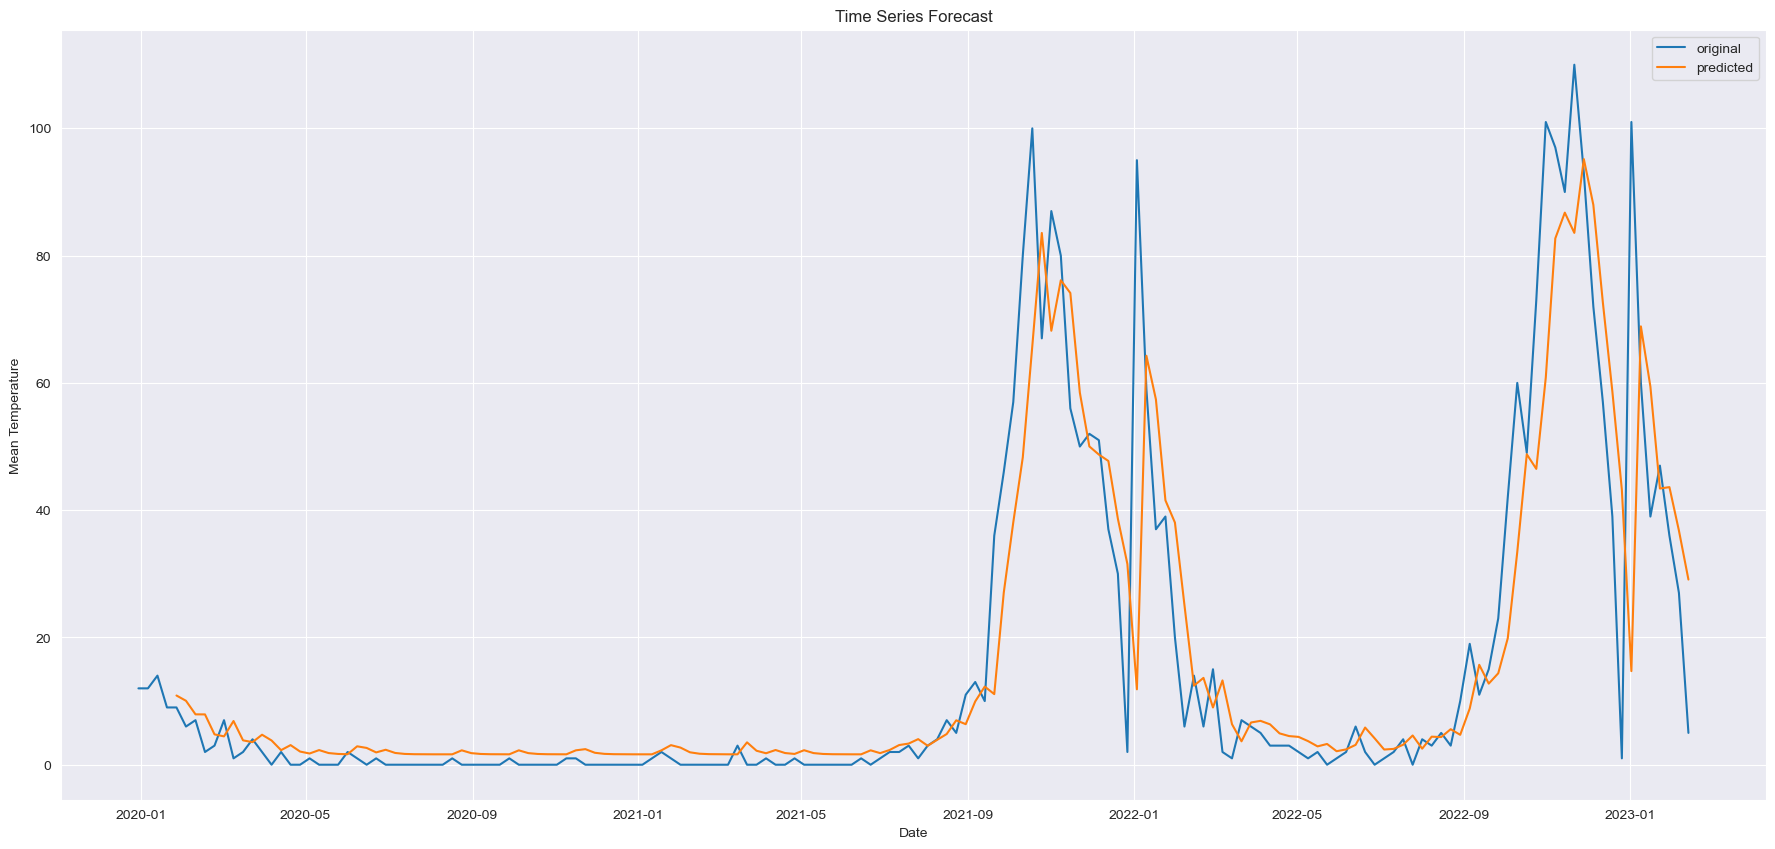

In [21]:

# fit model
model = ARIMA(ts, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit()

# predict
start_index = datetime(2020, 1, 27)
end_index = datetime(2023, 2, 13)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(ts.index, ts.RSV, label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

/Users/jonathanyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/jonathanyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/jonathanyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


error:  185.9892650562105


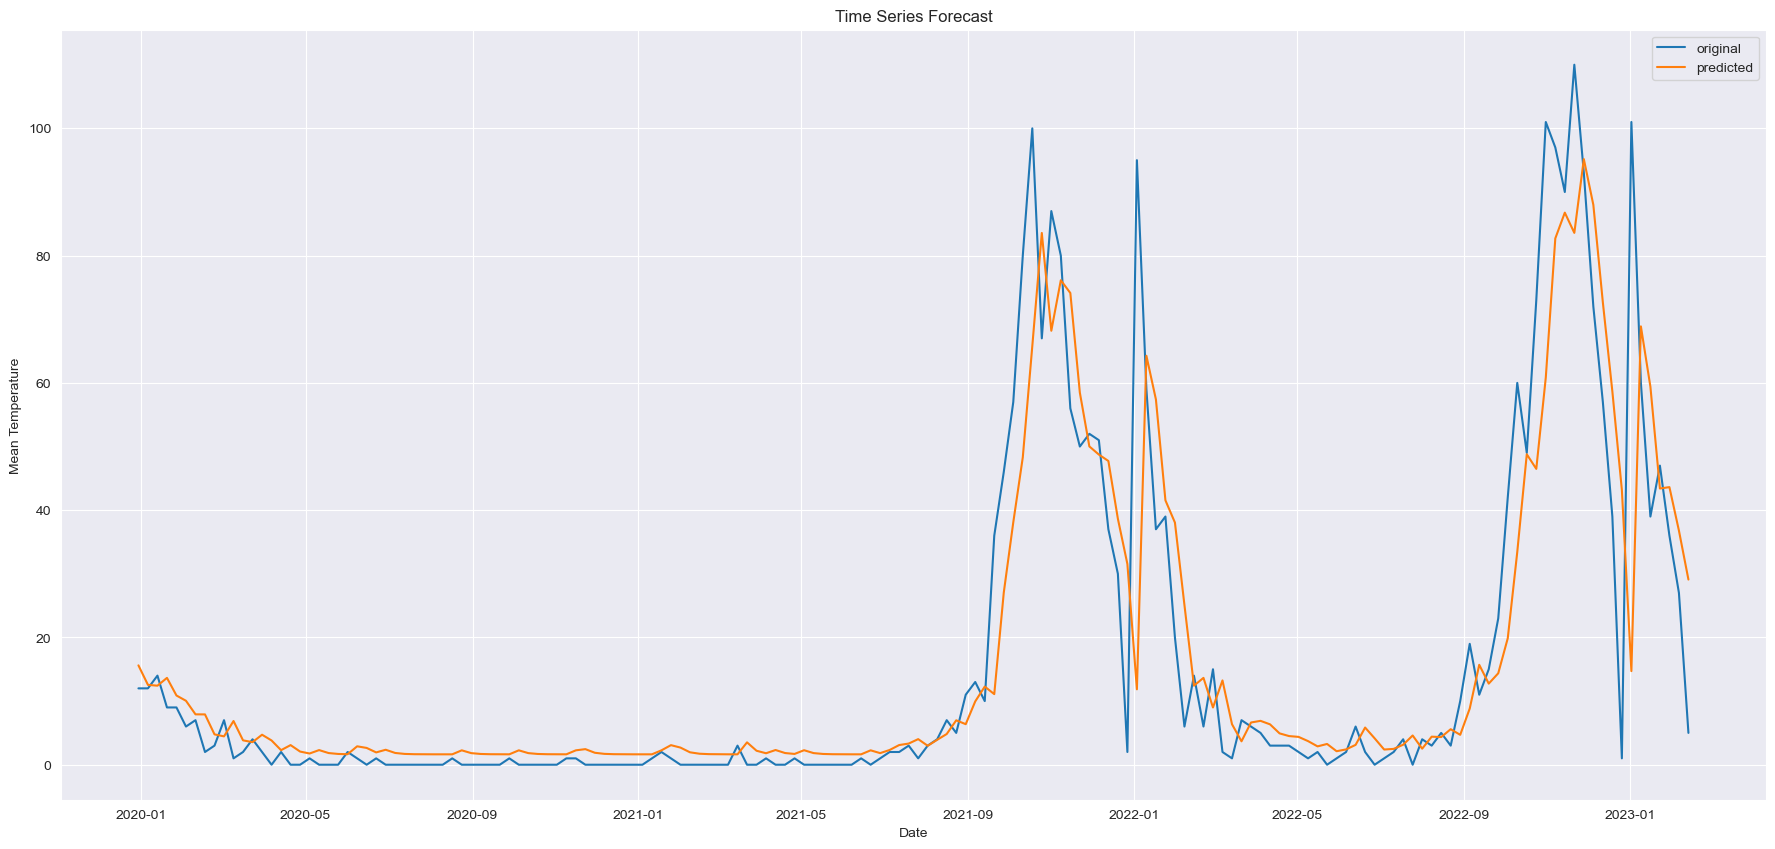

In [22]:
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(ts, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit()
forecast2 = model_fit2.predict()
error = mean_squared_error(ts, forecast2)
print("error: " ,error)
# visualization
plt.figure(figsize=(22,10))
plt.plot(ts.index,ts.RSV,label = "original")
plt.plot(forecast2,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.savefig('graph.png')

plt.show()